<a href="https://colab.research.google.com/github/JaganFoundr/PyTorchNN/blob/main/Improved%20CNN/ImprovedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#1
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [3]:
#2 Applying data normalization and data augmentation
statistic=((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) #mean and std deviation
train_transform = tt.Compose([tt.RandomCrop(size=32, padding=4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*statistic)]) # normalizing and augmenting the training set

test_transform = tt.Compose([tt.ToTensor(),
                             tt.Normalize(*statistic)]) #normalising the test set

# downloading the datasets and applying the transforms (for a moment training set is completely taken for training without
#splitting and testset is taken for validation and also for testing.
dataset=CIFAR10(root='./data', download=True, train=True, transform=train_transform)
validation_testset=CIFAR10(root='./data', download=True, train=False, transform=test_transform)
len(dataset)

100%|██████████| 170M/170M [00:05<00:00, 33.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


50000

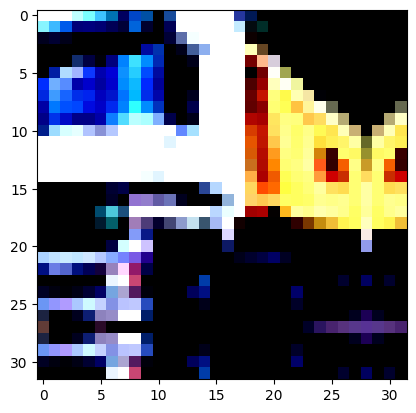

object number:  9
object name:  truck


In [4]:
#3
images, labels = dataset[1]
rgb_images=images.permute(1,2,0).numpy()
objectname=dataset.classes[labels]
plt.imshow(rgb_images)
plt.show()
print("object number: ", labels)
print("object name: ", objectname)

In [5]:
images.shape

torch.Size([3, 32, 32])

In [6]:
#4
batch_size=100

#num_workers are used to leverage multiple cpu cores and loading the images in parallel
#pin_memory avoids repeated allocation and deallocation of memory by using the same portion of memory(RAM) for loading each batch of data
#this is possible only because all of our images are 32x32 pixels
training_loader=DataLoader(dataset, batch_size,shuffle=True, num_workers=2, pin_memory=True)
validation_loader=DataLoader(validation_testset, batch_size, shuffle=False, num_workers=2, pin_memory=True)
print(len(training_loader.dataset))  # For training dataset
print(len(validation_loader.dataset))  # For test dataset


50000
10000


In [ ]:
#5
#defining the model, here we are gonna use a larger model, wideresnet22 having 22 convolutional layers, 1 key changes to our
# model is the addition of residual block in which the inputs get added back to the output feature map obtained by the passing
# of inputs through one or more convolutional layers
# also applying batch normalization after each convolutional layer to reduce loss and increase the accuracy very fast.

#conv2d function
def conv2d(inp, out, ks=3, stride=1):
  return nn.Conv2d(in_channels=inp,
                   out_channels=out,
                   kernel_size=ks,
                   stride=stride,
                   padding=ks//2,
                   bias=False)

# the order we need to follow is apply batchnormalization, relu function, conv2d layer
def batch_relu_conv2d(inp, out):
  return nn.Sequential(nn.BatchNorm2d(inp),
                       nn.ReLU(inplace=True),
                       conv2d(inp,out))

#things happening inside a residual block
class ResidualBlock(nn.Module):
    def __init__(self, inp, out, stride=1):
        super().__init__()
        self.batchnorm = nn.BatchNorm2d(inp)
        self.conv1 = nn.Conv2d(inp, out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = batch_relu_conv2d(out, out)

        # Define shortcut branch
        if inp != out or stride != 1:
            # Match both channels and spatial dimensions
            self.shortcut = nn.Conv2d(inp, out, kernel_size=1, stride=stride, bias=False)
        else:
            self.shortcut = nn.Identity()  # No change if dimensions match exactly

    def forward(self, x):
        x = F.relu(self.batchnorm(x), inplace=True)
        r = self.shortcut(x)  # Ensure `r` matches dimensions of `x`
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x + r


#making groups / blocks
def make_blocks(N,inp, out, stride):
  start=ResidualBlock(inp, out, stride)
  rest = [ResidualBlock(out, out) for j in range(1,N)]
  return [start]+rest

#flattening class
class Flatten(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x.view(x.size(0),-1)

#wide resnet class
class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, kernel=1, n_start=16):
    super().__init__()
    #increase channels to n_start using conv layer
    layers=[conv2d(3,n_start)]
    n_channels = [n_start]

    #add groups of basic blocks(increase channels and downsample)
    for i in range(n_groups):
      n_channels.append(n_start*(2**i)*kernel)
      stride=2 if i>0 else 1
      layers+=make_blocks(N, n_channels[i], n_channels[i+1], stride)

    #pool, flatten and add linear layers for classification
    layers+=[nn.BatchNorm2d(n_channels[3]),
             nn.ReLU(),
             nn.AdaptiveAvgPool2d(1),
             nn.Flatten(),
             nn.Linear(n_channels[3], n_classes)]

    self.features = nn.Sequential(*layers)

  def forward(self, x):
    return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3,N=3,n_classes=10,kernel=6)

model = wrn_22()

In [13]:
for images, labels in training_loader:
  prediction = model(images)

KeyboardInterrupt: 

In [ ]:
print(images.shape)
print(prediction.shape)